#### Notebook to create time series of precipitation efficiency (PE) from TC output

Assumes key integrated variables have been processed and written out by PE_write.py to single-level netcdf files.

James Ruppert  
jruppert@ou.edu  
1/5/23

In [29]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import subprocess
import sys
from mask_tc_track import mask_tc_track
import pandas as pd

#### Main settings

In [2]:
# NOTE: Using copied tracking from CTL for NCRF tests

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
nmem = 2

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 6 # radius (deg) limit for masking around TC center

# Strat/Conv index subset
# istrat_all=[0,1,2] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil, (-1 for off)
nrain=4 # np.size(istrat_all)
    # irain = 
    # 0 = conv+strat points
    # 1 = conv points
    # 2 = strat points
    # 3 = rainfall rate threshold

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/precip_eff/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

In [3]:
def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

In [4]:
# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# Get Lat/Lon
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
process = subprocess.Popen(['ls '+datdir+'/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()
lon1d=lon[0,:]
lat1d=lat[:,0]

In [5]:
# Create arrays

nt = np.zeros(ntest, dtype=np.int32)

for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()

    nt[itest]=i_nt

mf_ratio_t0 = np.zeros((nmem,nrain,nt[0]))
pe_mf_t0 = np.zeros((nmem,nrain,nt[0]))
pe_mp_t0 = np.zeros((nmem,nrain,nt[0]))

mf_ratio_t1 = np.zeros((nmem,nrain,nt[1]))
pe_mf_t1 = np.zeros((nmem,nrain,nt[1]))
pe_mp_t1 = np.zeros((nmem,nrain,nt[1]))

In [53]:
def plot_rainhist(x):
    n, bins, patches = plt.hist(x, 500, density=True, facecolor='g', alpha=0.75)
    plt.xlabel('mm/hr')
    plt.ylabel('Occurrence')
    plt.title('Rainfall Rate Distribution')
    plt.xlim(0.1, 80)
    # plt.ylim(0, 0.03)
    # plt.grid(True)
    plt.show()

#### Main loop

In [59]:
for itest in range(ntest):

    print('Running test: ',tests[itest])

    for imemb in range(nmem):

        print('Running imemb: ',memb_all[imemb])

        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/'
        # track_file = datdir+'track_'+var_track+'_'+ptrack+'hPa.nc'
        # Localize to TC track
        # NOTE: Using copied tracking from CTL for NCRF tests
        trackfil_ex=''
        if 'ncrf' in tests[itest]:
            trackfil_ex='_ctlcopy'
        track_file = datdir+'track_'+var_track+trackfil_ex+'_'+ptrack+'hPa.nc'

        # Read variables

        # Strat
        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'
        varfil_main = Dataset(datdir+'strat.nc')
        strat = varfil_main.variables['strat'][:,:,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
        varfil_main.close()

        # Rain
        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'
        varfil_main = Dataset(datdir+'rainrate.nc')
        rain = varfil_main.variables['rainrate'][:,:,:,:]/24 # mm/d --> mm/hr
        varfil_main.close()

        # rain = np.ma.masked_where(rain <= 3, rain)
        # print(rain.min())
        # plot_rainhist(rain.flatten())
        # sys.exit()

        # PE variables
        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'
        varfil_main = Dataset(datdir+'precip_eff_vars.nc')
        vmfu = varfil_main.variables['vmfu'][:,:,:,:] # kg/m/s
        vmfd = varfil_main.variables['vmfd'][:,:,:,:] # kg/m/s
        condh = varfil_main.variables['condh'][:,:,:,:] # mm/d
        condh /= 24 # mm/d --> mm/hr
        varfil_main.close()

        t0=0
        t1=nt[itest]

        # Mask out around TC center
        rain = mask_tc_track(track_file, rmax, rain, lon, lat, t0, t1)
        strat = mask_tc_track(track_file, rmax, strat, lon, lat, t0, t1)
        strat = np.ma.filled(strat, fill_value=np.nan)
        rain = np.ma.filled(rain, fill_value=np.nan)

        # Average across raining points
        for it in range(nt[itest]):
            for krain in range(nrain):
                # krain=3

                # conv+strat points
                if krain == 0:
                    irain = ((strat[it,0,:,:] == 1) | (strat[it,0,:,:] == 2)).nonzero()
                # conv points
                elif krain == 1:
                    irain = (strat[it,0,:,:] == 1).nonzero()
                # strat points
                elif krain == 2:
                    irain = (strat[it,0,:,:] == 2).nonzero()
                # rainfall rate threshold
                elif krain == 3:
                    rain_thresh = 3. # mm/hr
                    irain = (rain[it,0,:,:] >= rain_thresh).nonzero()

                condh_avg = np.nanmean(condh[it,0,irain[0],irain[1]])
                rain_avg = np.nanmean(rain[it,0,irain[0],irain[1]])
                vmfu_avg = np.nanmean(vmfu[it,0,irain[0],irain[1]])
                vmfd_avg = np.nanmean(vmfd[it,0,irain[0],irain[1]])

                # if it == 5:
                #     print(vmfu_avg)
                #     print(vmfd_avg)
                #     raise SystemExit()

                mf_ratio = -1 * vmfd_avg / vmfu_avg
                pe_mp = rain_avg / condh_avg

                if itest == 0:
                    mf_ratio_t0[imemb,krain,it] = mf_ratio
                    pe_mf_t0[imemb,krain,it] = 1 - mf_ratio
                    pe_mp_t0[imemb,krain,it] = pe_mp
                elif itest == 1:
                    mf_ratio_t1[imemb,krain,it] = mf_ratio
                    pe_mf_t1[imemb,krain,it] = 1 - mf_ratio
                    pe_mp_t1[imemb,krain,it] = pe_mp

Running test:  ctl
Running imemb:  memb_01
(20253,)
(20253,)
(30522,)


/home/jamesrup/miniconda3/envs/plotting/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:222: UserWarning: Warning: converting a masked element to nan.
  return a.dtype.type(a / b)
/tmp/ipykernel_16046/1481697357.py:85: RuntimeWarning: Mean of empty slice
  rain_avg = np.nanmean(rain[it,0,irain[0],irain[1]])


SystemExit: 

/home/jamesrup/miniconda3/envs/plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
# print(np.nanmean(pe_mf_t0[0,:,:],axis=1))
# print(np.nanmean(pe_mp_t0[0,:,:],axis=1))

---
### Plotting routines

In [20]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

/tmp/ipykernel_16046/1500355169.py:52: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(mf0, axis=0)


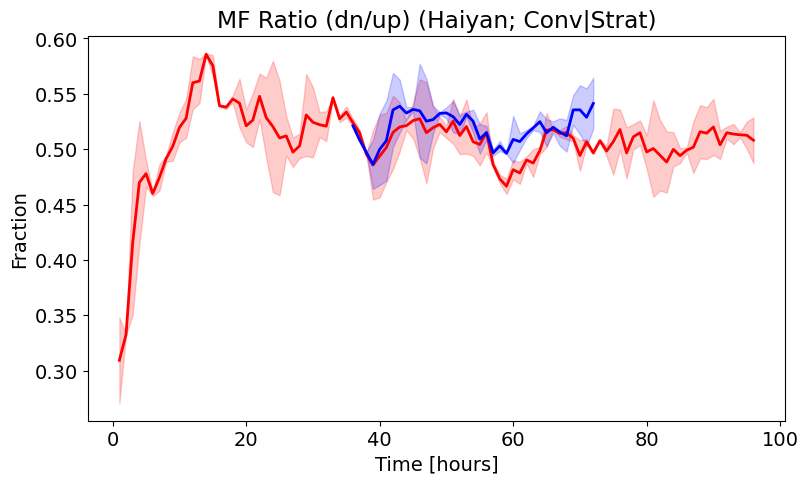

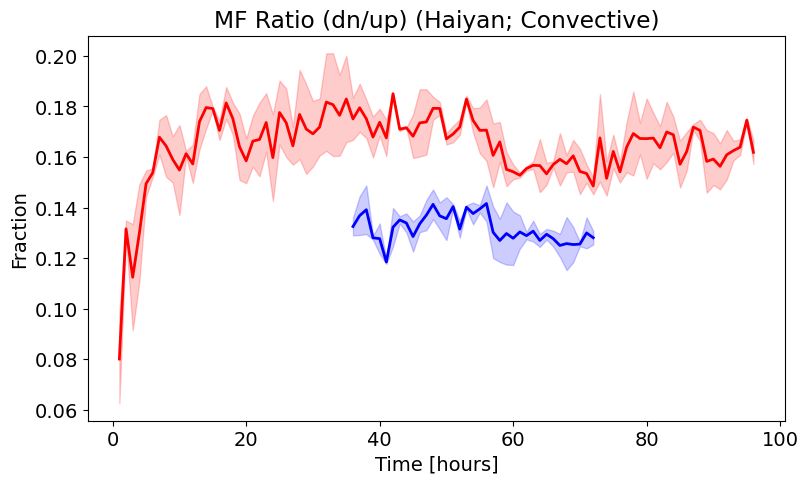

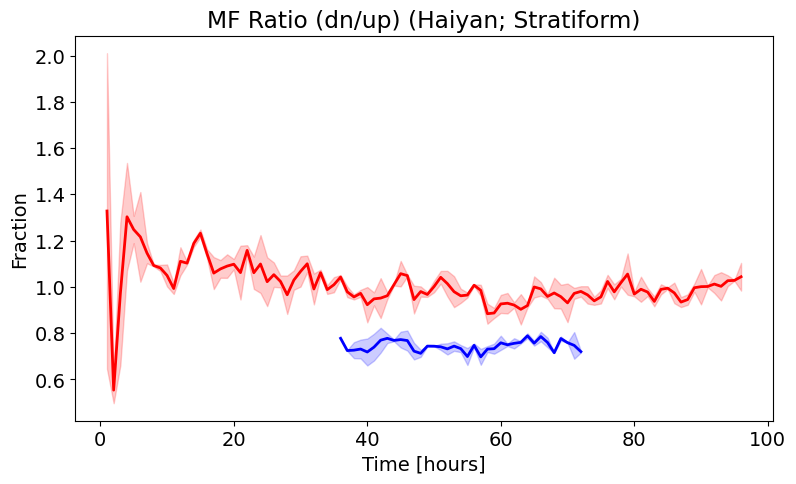

/tmp/ipykernel_16046/1500355169.py:63: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(mf1, axis=0)


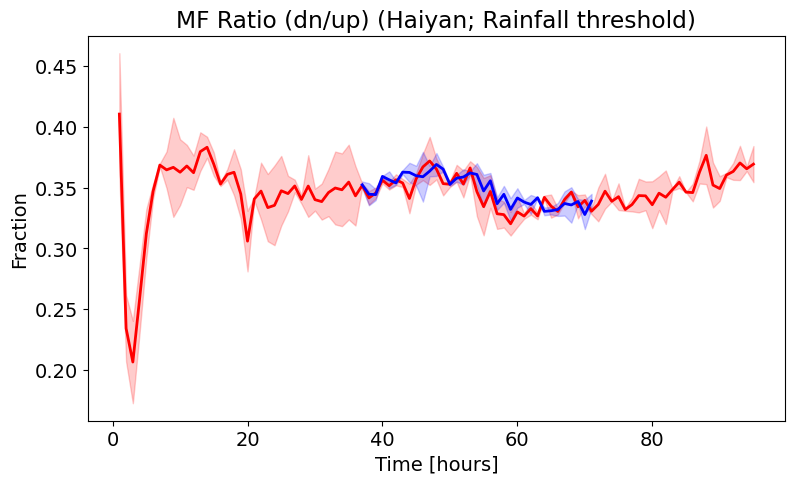

In [58]:
for krain in range(nrain):
# for krain in range(1):

    # conv+strat points
    if krain == 0:
        fig_extra='CS'
        raintag='Conv|Strat'
    # conv points
    elif krain == 1:
        fig_extra='conv'
        raintag='Convective'
    # strat points
    elif krain == 2:
        fig_extra='strat'
        raintag='Stratiform'
    # rainfall rate threshold
    elif krain == 3:
        fig_extra='rainthresh'
        raintag='Rainfall threshold'

    mf0 = mf_ratio_t0[:,krain,:]
    pe_mf0 = pe_mf_t0[:,krain,:]
    pe_mp0 = pe_mp_t0[:,krain,:]

    mf1 = mf_ratio_t1[:,krain,:]
    pe_mf1 = pe_mf_t1[:,krain,:]
    pe_mp1 = pe_mp_t1[:,krain,:]

    # pvar_pd1 = pd.DataFrame(pvar1)
    # pvar1_smooth = pvar_pd1.rolling(window=3, center=True, closed='both', axis=0).mean()
    # pvar_pd2 = pd.DataFrame(pvar2)
    # pvar2_smooth = pvar_pd2.rolling(window=3, center=True, closed='both', axis=0).mean()

### Mass flux plot ##############################################

    # create figure
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(111)

    ax.set_title('MF Ratio (dn/up) ('+storm.capitalize()+'; '+raintag+')')#, fontsize=20)
    ax.set_ylabel('Fraction')
    ax.set_xlabel('Time [hours]')

    t_range=[30,80]
    # plt.xlim(t_range)

    color_t0 = 'red'
    color_t1 = 'blue'

    # Test 0

    mean_t0 = np.nanmean(mf0, axis=0)
    std_t0 = np.nanstd(mf0, axis=0)

    tshift = get_tshift(tests[0])
    xdim = range(0+tshift, nt[0]+tshift)

    plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
    plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

    # Test 1

    mean_t1 = np.nanmean(mf1, axis=0)
    std_t1 = np.nanstd(mf1, axis=0)

    tshift = get_tshift(tests[1])
    xdim = range(0+tshift, nt[1]+tshift)

    plt.plot(xdim, mean_t1, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
    plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

    # plt.legend(loc="upper right")

    plt.show()
    # plt.savefig(figdir+'tser_'+storm+'_mf_'+fig_extra+'.png',dpi=200, facecolor='white', \
    #             bbox_inches='tight', pad_inches=0.2)
    # plt.close()